# `CausalGraphicalModels`

`CausalGraphicalModel` is a python module for describing and manipulating [Causal Graphical Models](https://en.wikipedia.org/wiki/Causal_graph) and [Structural Causal Models](https://en.wikipedia.org/wiki/Structural_equation_modeling). Behind the curtain, it is a light wrapper around the python graph library [networkx](https://networkx.github.io/).

This notebook is designed to give a quick overview of the functionality of this package.

# StructuralCausalModels

For Structural Causal Models (SCM) we need to specify the functional form of each node:

In [1]:
from causalgraphicalmodels import StructuralCausalModel
import numpy as np

scm = StructuralCausalModel({
    "born_even_day": lambda n_samples: np.random.binomial(n=1,p=0.7,size=n_samples),
    "anxiety": lambda n_samples: np.random.binomial(n=1,p=0.7,size=n_samples),
    "peer_pressure": lambda n_samples: np.random.binomial(n=1,p=0.7,size=n_samples),
    "genetics": lambda n_samples: np.random.binomial(n=1,p=0.7,size=n_samples),
    "smoking": lambda anxiety, peer_pressure, n_samples: anxiety + peer_pressure,
    "yellow_fingers": lambda smoking, n_samples: np.random.normal(loc=smoking, scale=0.1),
    "attention_disorder": lambda genetics, n_samples: genetics**2,
    "lung_cancer": lambda smoking, genetics, n_samples: smoking * genetics,
    "allergy": lambda n_samples: np.random.binomial(n=1,p=0.7,size=n_samples),
    "coughing": lambda allergy, lung_cancer, n_samples: allergy + lung_cancer,
    "fatigue": lambda coughing, lung_cancer, n_samples: coughing + lung_cancer,
    "car_accident": lambda fatigue, attention_disorder, n_samples: fatigue * attention_disorder,
})

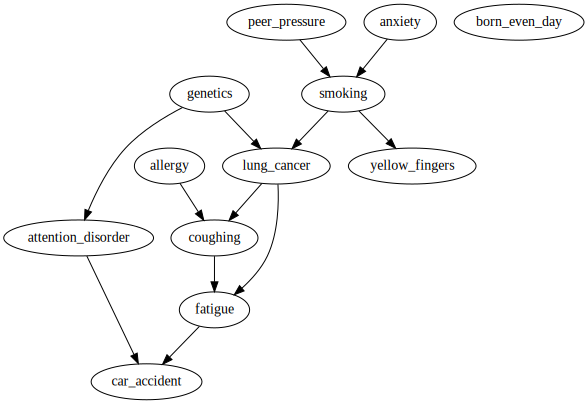

In [2]:
scm.cgm.draw()

In [3]:
ds = scm.sample(n_samples=100)

ds.head()

,allergy,genetics,attention_disorder,peer_pressure,anxiety,smoking,yellow_fingers,lung_cancer,coughing,fatigue,car_accident,born_even_day
0,0,1,1,1,1,2,1.960337,2,2,4,4,1
1,1,1,1,0,1,1,1.033738,1,2,3,3,0
2,0,1,1,0,1,1,0.942633,1,1,2,2,0
3,1,1,1,1,1,2,2.162845,2,3,5,5,0
4,0,0,0,1,1,2,2.081452,0,0,0,0,0


The only requirement on the functions are:
 - that variable names are consistent 
 - each function accepts keyword variables in the form of `numpy` arrays and output numpy arrays of shape [n_samples] 
 - that in addition to it's parents, each function takes a `n_samples` variables indicating how many samples to generate 
 - that any function acts on each row independently. This ensure that the output samples are independent
 
Wrapping these functions in the `StructuralCausalModel` object allows us to easily generate samples: 

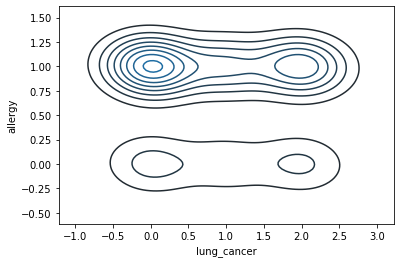

In [4]:
# and visualise the samples
import seaborn as sns

%matplotlib inline

sns.kdeplot(
    data=ds.lung_cancer,
    data2=ds.allergy,
)

And to access the implied CGM"

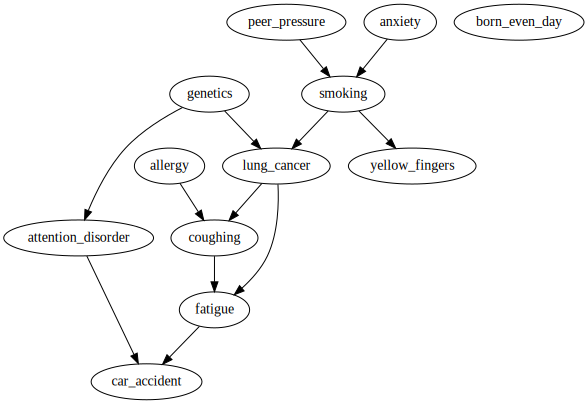

In [5]:
scm.cgm.draw()

And to apply an intervention:

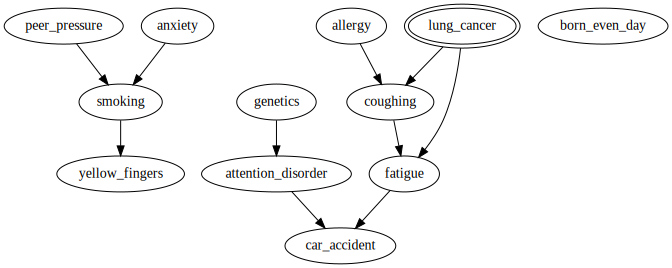

In [6]:
scm_do = scm.do("lung_cancer")

scm_do.cgm.draw()

And sample from the distribution implied by this intervention:

In [7]:
scm_do.sample(n_samples=5, set_values={"lung_cancer": np.arange(5)})

,allergy,lung_cancer,coughing,fatigue,genetics,attention_disorder,car_accident,peer_pressure,anxiety,smoking,yellow_fingers,born_even_day
0,0,0,0,0,1,1,0,0,0,0,-0.069327,1
1,1,1,2,3,1,1,3,1,1,2,1.989477,1
2,1,2,3,5,1,1,5,1,1,2,2.020766,1
3,0,3,3,6,1,1,6,1,1,2,1.952722,1
4,1,4,5,9,1,1,9,0,1,1,0.962361,0
